In [1]:
from osgeo import gdal
from os import listdir
from PIL import Image, ImageSequence
from skimage.io import imread, imsave, imshow
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm

c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
options = gdal.TranslateOptions(format='PNG', bandList=[1], creationOptions=['WORLDFILE=YES'], outputType=gdal.GDT_Byte)

In [3]:
import numpy as np

def calculate_cdf(gray_image):
    hist, _ = np.histogram(gray_image, bins=256, range=(0, 1), density=True)
    cdf = np.cumsum(hist) / 256
    return cdf


def hist_equalization(gray_image):
    cdf = calculate_cdf(gray_image)

    # map all values to cdf's values
    # cdf(gray_image)
    gray_image = np.interp(gray_image, np.linspace(0, 1, 256), cdf)

    return gray_image

In [4]:
def filt(image, kernel, *, kernel_size=3, padd=0, fill_mode="reflect"):
    """
    kernel - arbitrary function with one argument - window
    fill_mode - 'constant', 'symmetric', 'reflect'
    """
    if padd:
        padding = [(padd, padd), (padd, padd)]
        if image.ndim == 3:
            padding += [(0, 0)]

        # use np.pad for image padding
        image = np.pad(image, padding, mode=fill_mode)

    h_range = range(image.shape[0] - (kernel_size - 1))
    w_range = range(image.shape[1] - (kernel_size - 1))
    channels = image.shape[-1:] if image.ndim == 3 else ()

    # define new image
    new_image = np.empty((len(h_range), len(w_range)) + channels, dtype=image.dtype)

    for i in tqdm(h_range, total=len(h_range)):
        for j in w_range:
            # define image slice - window
            window = image[i : i + kernel_size, j : j + kernel_size]

            # apply kernel to window
            value = kernel(window)

            # write out the result
            new_image[i, j] = value

    return new_image

def lahe_kernel(window):
    h, w = window.shape[:2]

    # calculate cdf of image's color histogram
    cdf = calculate_cdf(window)

    # extract the middle pixel from the window
    center = window[h // 2, w // 2]

    # map only the extracted value using the whole cdf
    value = np.interp(center, np.linspace(0, 1, 256), cdf)

    return value

In [5]:
def median_filter(window):
    channels = window.shape[-1:] if window.ndim == 3 else ()

    # sort values
    values = window.copy().reshape((-1,) + channels)
    values.sort(axis=0)

    # choose mid value
    # median = np.median(window, axis=(0, 1))
    middle, odd = divmod(values.shape[0], 2)
    median = values[middle - (not odd) : middle + 1].mean(axis=0)

    return median

In [6]:
def percentile_contrast(image, lower, upper):
    # Calculate the percentiles
    lower_value = np.percentile(image, lower)
    upper_value = np.percentile(image, upper)

    # Apply contrast stretching
    stretched_data = np.clip((image - lower_value) / (upper_value - lower_value), 0, 1)

    return stretched_data

In [ ]:
squares = [
    [525146, 8900005, 550100, 8875018], # 1
    [550146, 8900005, 575100, 8875018], # 2
    [575146, 8900005, 600100, 8875018], # 3
    [500146, 8900005, 525100, 8875018], # 4
    [575146, 8875005, 600100, 8850018], # 5
    [500146, 8875005, 525100, 8850018], # 6
    [575146, 8925005, 600100, 8900005], # 7
     [550146, 8925005, 600100, 8875018], # 8
     [600100, 8900005, 625100, 8875018], # 9
     [475146, 8900005, 500146, 8875018], # 10
     [575100, 8875018, 600100, 8850018], # 11
     [525146, 8875005, 550100, 8850018], # 12
]

In [7]:
squares_new = [
     [575146, 8925005, 600100, 8900005], # 7
     [550146, 8925005, 600100, 8875018], # 8
     [600100, 8900005, 625100, 8875018], # 9
     [475146, 8900005, 500146, 8875018], # 10
     [575100, 8875018, 600100, 8850018], # 11
     [525146, 8875005, 550100, 8850018], # 12
]

In [9]:
folder = './0804'

for file in listdir(folder):
    if file.endswith('.tif'):
        tif_file = gdal.Open(folder +  '/' + file)     
        counter = 0   
        for square in squares_new:
            file_name = "translated_" + str(counter) + "_" + file #.replace('.tif', '.png')
            ds = gdal.Translate(file_name, tif_file, projWin=square)   
            counter+=1 

In [10]:
def open_tif_as_png(img_path):

    # Open the GeoTIFF file
    dataset = gdal.Open(img_path)

    # Read the single band (assuming it's the first band)
    band = dataset.GetRasterBand(1)

    # Read the data as a numpy array
    data = band.ReadAsArray()

    # Normalize the data to the range [0, 255]
    data_min = np.min(data)
    data_max = np.max(data)
    normalized_data = 255 * (data - data_min) / (data_max - data_min)
    normalized_data = normalized_data.astype(np.uint8)

    # Save the normalized data as a PNG image    
    return normalized_data

In [ ]:
tr_folder = './0804/translated/new'

for file in listdir(tr_folder):
    if file.endswith('.tif'):
        png = open_tif_as_png(tr_folder + '/' + file)
        img_f32 = png.astype(np.float32) / 255

        #filtered = filt(img_f32, median_filter, kernel_size=5, padd=2)

        stretched_data = percentile_contrast(img_f32, 5, 95)

        image = Image.fromarray(stretched_data)
        extrema = image.convert("L").getextrema()
        if extrema == (0, 0):
            continue

        imsave('./pngs/filtered' + file.replace(".tif", "_new.png"), (stretched_data * 255).astype(np.uint8))

C:\Users\jeday\AppData\Local\Temp\ipykernel_25784\1995531987.py:7: RuntimeWarning: invalid value encountered in divide
  stretched_data = np.clip((image - lower_value) / (upper_value - lower_value), 0, 1)


# ниже эксперименты #

In [13]:
print("Data type:", data.dtype)
print("Min value:", np.min(data))
print("Max value:", np.max(data))

Data type: float32
Min value: 3249.119
Max value: 1477902.1


In [ ]:
im = Image.open("translated_subset_3_of_S1A_EW_GRDM_1SDH_20240925T015158_20240925T015303_055815_06D1F4_5C9C_TC.tif")
#navigate to the folder were the layers are going to be saved 

#loop over layers and export jpeg instances
for i, page in enumerate(ImageSequence.Iterator(im)):
    #page.mode = 'I'
    page.point(lambda i:i*(1./256)).convert('L').save(str(i)+'.jpeg')

In [16]:
from skimage.color import rgb2gray

im_2 = imread("output.png")
img_f32 = im_2.astype(np.float32) / 255

In [22]:
he_f32 = hist_equalization(img_f32)

In [69]:
def plot_image_with_hist(image):
    # flatten image cause in image's histogram
    # there is no need to keep geometric information
    values = image.flatten()

    plt.subplot(1, 2, 1)
    # plot the histogram
    plt.hist(values, bins=256, range=(0, 1), density=True)

    plt.subplot(1, 2, 2)
    # show the image
    # plt.imshow(image, cmap="gray", vmin=0, vmax=1)
    image = np.repeat(image[..., None], 3, axis=-1)
    plt.imshow(image)

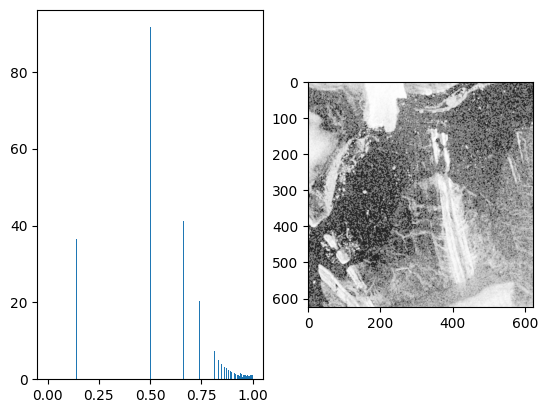

In [23]:
plot_image_with_hist(he_f32)

100%|██████████| 625/625 [01:10<00:00,  8.86it/s]


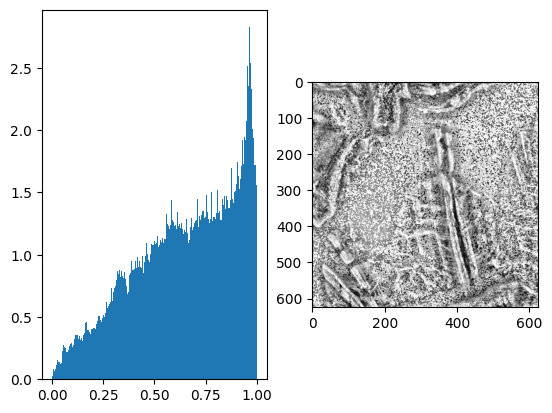

In [28]:
lahe_f32 = filt(img_f32, lahe_kernel, kernel_size=51, padd=25, fill_mode="reflect")
plot_image_with_hist(lahe_f32)

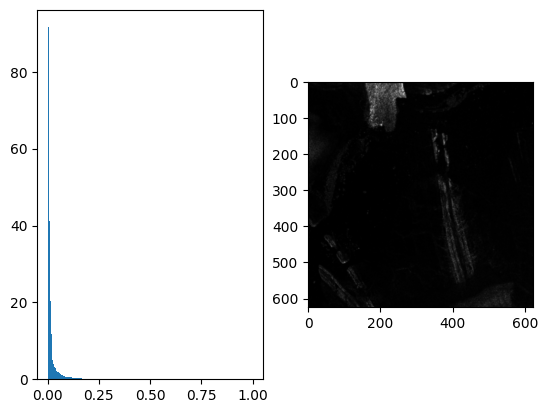

In [29]:
lin_stretch_img = img_f32 - img_f32.min()
lin_stretch_img = lin_stretch_img / lin_stretch_img.max()
plot_image_with_hist(lin_stretch_img)

In [ ]:
darkened_u8 = (255 * img_f32).clip(0, 255).round().astype(np.uint8)
darkened_fp32 = darkened_u8.astype(np.float32) / 255
brigthened_fp32 =10 * img_f32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


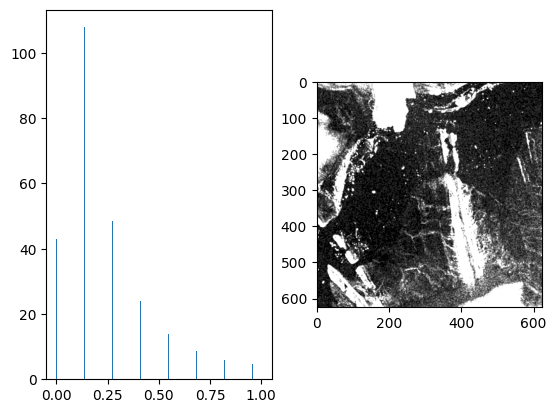

In [41]:
plot_image_with_hist(35 * img_f32)

100%|██████████| 625/625 [00:03<00:00, 160.09it/s]


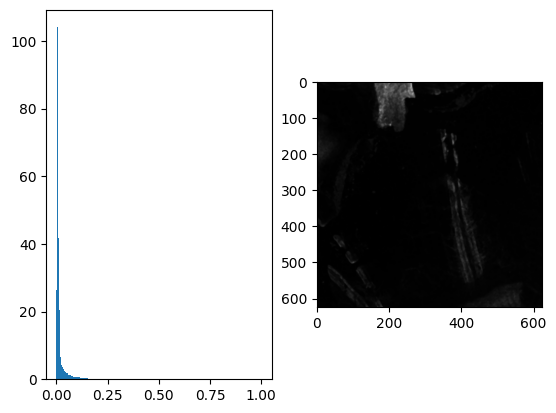

In [87]:
filtered = filt(img_f32, median_filter, kernel_size=5, padd=2)
plot_image_with_hist(filtered)

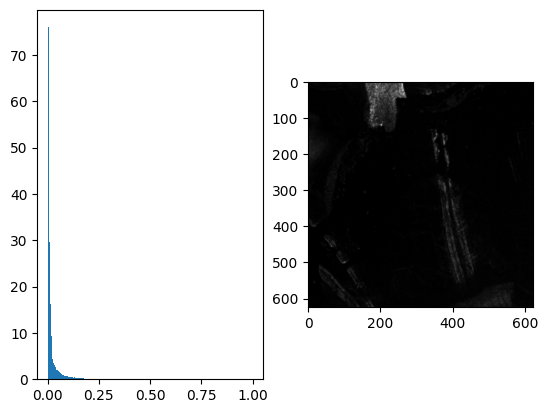

In [84]:
from scipy.ndimage import gaussian_filter

# Apply Gaussian blur to reduce noise
smoothed_data = gaussian_filter(img_f32, sigma=0.5)  # Adjust sigma as needed
plot_image_with_hist(smoothed_data)

In [71]:
image_to_save = smoothed_data * 35
data_min = np.min(image_to_save)
print(data_min)
data_max = np.max(image_to_save)
print(data_max)
normalized_data = (image_to_save - data_min) / (data_max - data_min)

# Save the normalized data as a PNG image
imsave('filtered.png', (normalized_data * 255).astype(np.uint8))

2.4583229e-09
27.57154


In [60]:
print("Min:", np.min((35 * img_f32)))
print("Max:", np.max((35 * img_f32)))
print("Mean:", np.mean((35 * img_f32)))
print("Std Dev:", np.std((35 * img_f32)))

Min: 0.0
Max: 35.0
Mean: 0.7464411
Std Dev: 1.7847582


In [89]:
imsave('filtered.png', (stretched_data * 255).astype(np.uint8))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


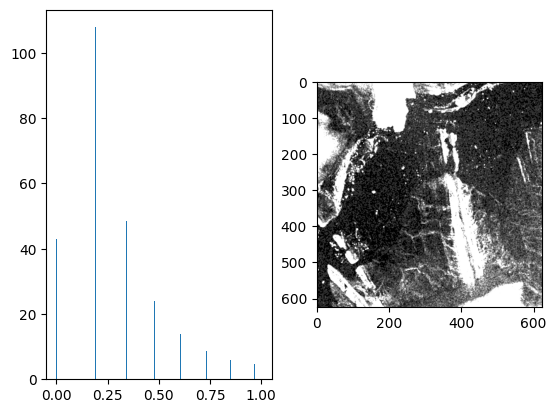

In [44]:
gamma = 1 / 1.2

gamma_correction = (35 * img_f32)**gamma

plot_image_with_hist(gamma_correction)